# CO2 Rate Switchpoint Analysis

In [35]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [9]:
# http://esrl.noaa.gov/gmd/ccgg/trends/global.html
data = pd.read_csv('data/co2_rate.csv')

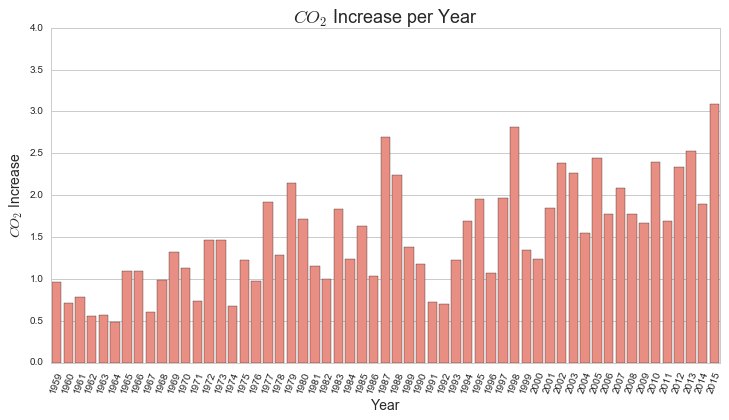

In [34]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=70)
sns.barplot(x='year', y='ppm_per_year', data=data, color='salmon')
plt.ylim((0,4))
plt.ylabel('$CO_2$ Increase', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('$CO_2$ Increase per Year', fontsize=18)
plt.show()

In [36]:
years = len(data['year'])

In [87]:
with pm.Model() as model:
    
    # prior for distribution of switchpoint year
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=years)
    
    # prior for pre- and post-switch intercept
    a_0 = pm.Normal('a_0', 0, 1)
    a_1 = pm.Normal('a_1', 0, 1)    
    
    # prior for pre- and post-switch slope
    b_0 = pm.HalfNormal('b_0', 0.1)
    b_1 = pm.HalfNormal('b_1', 0.1)
    
    # priors for sigma 
    s_0 = pm.HalfCauchy('s_0', 1)
    s_1 = pm.HalfCauchy('s_1', 1)
    
    # Assign slopes to appropriate pre- and post-switchpoint locations
    idx = np.arange(years)
    intercept = pm.switch(switchpoint <= idx, a_0, a_1)
    slope = pm.switch(switchpoint <= idx, b_0, b_1)
    sigma = pm.switch(switchpoint <= idx, s_0, s_1)
    
    # Data likelihood
    mu = intercept + slope * data['year']
    co2_rate = pm.Normal('co2_rate', mu=mu , sd=sigma, observed=data['ppm_per_year'])

In [88]:
n = 100000
with model:
    start = pm.find_MAP()
    trace = pm.sample(n, step=pm.Metropolis(), start=start)

 [-----------------100%-----------------] 100000 of 100000 complete in 132.8 sec

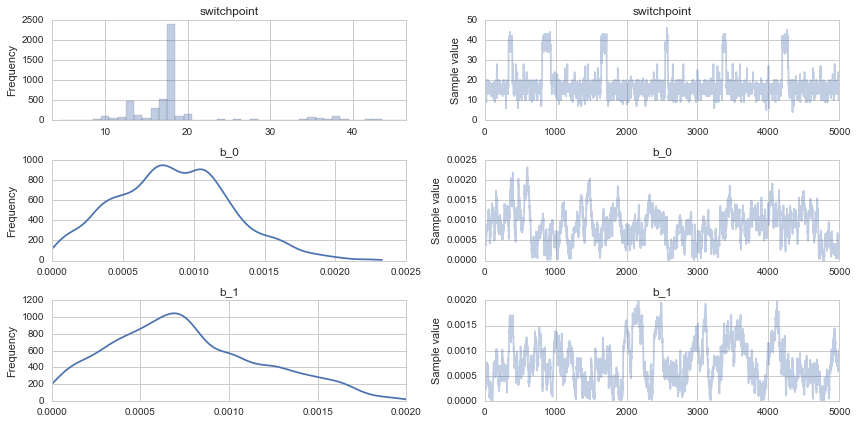

In [89]:
# Only use last half of trace, and every 10th point
pm.traceplot(trace[-n/2::10], vars=['switchpoint', 'b_0', 'b_1'])
plt.show()

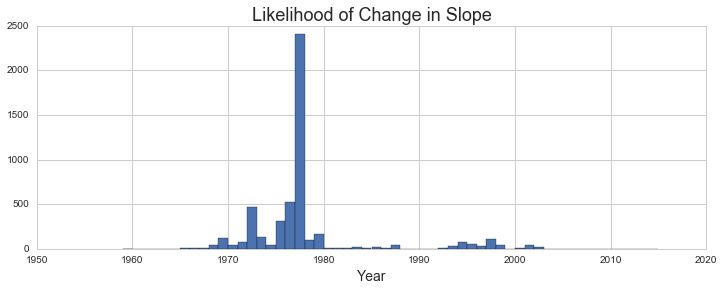

In [90]:
plt.figure(figsize=(12,4))
plt.hist(trace[-n/2::10]['switchpoint']+1959, bins=np.arange(1959, 2016))
plt.title('Likelihood of Change in Slope', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.show()

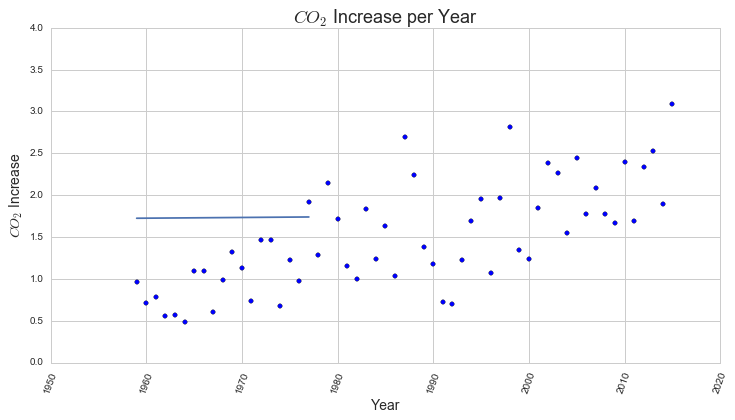

In [91]:
plt.figure(figsize=(12,6))

plt.xticks(rotation=70)
plt.scatter(data['year'], data['ppm_per_year'])
plt.ylim((0,4))
plt.ylabel('$CO_2$ Increase', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.title('$CO_2$ Increase per Year', fontsize=18)

x = np.arange(1959, 1978)
y = np.median(trace[-n/2::10]['a_0']) + np.median(trace[-n/2::10]['b_0']) * x
plt.plot(x, y)

plt.show()

In [86]:
np.median(trace[-n/2::10]['b_0'])

0.0010193239801723295